In [10]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

import sys

sys.path.append('..')

from algorithms.random_policy import RandomPolicy
from algorithms.sequence_models.decision_sequence_policy import DTPolicy
from algorithms.sequence_models.decision_transformer.decision_transformer import DecisionTransformer
from algorithms.sequence_models.evaluate import evaluate_on_env
from data.door_key_dataset import DoorKeyDataset
from data.random_walk_dataset import RandomWalkDataset
from envs.door_key import DoorKeyEnv, DoorKeyEnvSmall
from data.trajectory import LimitedContextWrapper
from algorithms.sequence_models.config import TrainConfig
from algorithms.sequence_models.decision_transformer.trainer import TrainerDT
from envs.random_walk import RandomWalkEnv
from experiment import Experiment
import gymnasium as gym
from functools import partial

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device is ", device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
device is  cuda


In [11]:
from envs.carnival import get_carnival_env

In [12]:
# env = get_carnival_env()
# obs, _ = env.reset()
# obs.shape
# plt.imshow(obs)

In [13]:
from algorithms.sequence_models.decision_sequence_policy import DecisionSequenceModel
from algorithms.sequence_models.decision_S4.dts4 import DecisionS4
import torch
import torch.nn as nn

class CNNFeatureExtractor(nn.Module):
    FEATURE_DIM = 64
    
    def __init__(self):
        super(CNNFeatureExtractor, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 3 * 2, 128)
        self.fc2 = nn.Linear(128, 64)
    
    def forward(self, x):
        first_shape = x.shape[:-3]
        second_shape = x.shape[-3:]
        x = x.view(-1, *second_shape)
        x = x.permute([0, 3, 1, 2])
        
        # Apply convolutional and pooling layers
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.pool(torch.relu(self.conv4(x)))
        x = self.pool(torch.relu(self.conv5(x)))
        x = self.pool(torch.relu(self.conv6(x)))
        x = x.reshape(-1, 128 * 3 * 2)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = x.view(*first_shape, self.FEATURE_DIM)
        return x

# wrapper over DT. passes the features of the input through
class CarnivalDTWrapper(DecisionSequenceModel):
    def __init__(self, state_dim, act_dim, **kwargs):
        # change the feature size midways
        super(CarnivalDTWrapper, self).__init__(state_dim=CNNFeatureExtractor.FEATURE_DIM, act_dim=act_dim)
        self.feature_extractor = CNNFeatureExtractor()
        self.sequence_model = DecisionTransformer(state_dim=self.state_dim, act_dim=self.act_dim, **kwargs) 
        
    def forward(self, timesteps, states, actions, returns_to_go):
        states = self.feature_extractor(states)
        return self.sequence_model(timesteps, states, actions, returns_to_go)


class CarnivalS4Wrapper(DecisionSequenceModel):
    def __init__(self, state_dim, act_dim, **kwargs):
        super(CarnivalS4Wrapper, self).__init__(state_dim=CNNFeatureExtractor.FEATURE_DIM, act_dim=act_dim)
        self.feature_extractor = CNNFeatureExtractor()
        self.sequence_model = DecisionS4(state_dim=self.state_dim, act_dim=self.act_dim, **kwargs) 

    def forward(self, timesteps, states, actions, returns_to_go):
        states = self.feature_extractor(states)
        return self.sequence_model(timesteps, states, actions, returns_to_go)


In [18]:
from data.carnival_dataset import CarnivalDataset

env = get_carnival_env()

episode_length = 500 # todo the more the better but then it becomes slower
config = TrainConfig(max_eval_ep_len=episode_length, context_len=episode_length,
                     eval_model_interval=40,
                     batch_size=32) # because it doesn't fit on my gpu

n_trajectories = 2000
experiment_name = f"experiment_carnival_dataset_size={n_trajectories}"
if CarnivalDataset.exists(experiment_name):
    traj_dataset = CarnivalDataset.load(experiment_name)
else:
    traj_dataset = CarnivalDataset(env, n_trajectories=n_trajectories, reward_scale=1000)
    traj_dataset.save(experiment_name)


In [19]:
from final_experiments.comparison_experiment import AutomatedComparisonExperiment

comparison_experiment = AutomatedComparisonExperiment(
    env=env,
    traj_dataset=traj_dataset,
    config=config,
    device=device,
    rtgs_for_train_eval=[1000, 2000, 5000, 10000, 30000], # todo change for other envs
    rtgs_final_test=np.linspace(1000, 50000, 15, endpoint=True), # todo change for other envs
    env_name=f"Carnival-V4", # todo change for other envs
    experiment_name="automated_comparison",
    DT_Class=CarnivalDTWrapper,
    S4_Class=CarnivalS4Wrapper
)

INFO:algorithms.sequence_models.decision_S4.s4:Constructing S4 (H, N, L) = (128, 32, None)


s4 : number of parameters 1108519
dt : number of parameters 1637287


In [20]:
epochs = 5

distribution of rewards in the dataset
training started


  0%|          | 0/5 [00:00<?, ?it/s]

time elapsed: 0:00:19
num of updates: 100
loss: 0.32876
lr 0.00001
grad_norm 0.12213
time elapsed: 0:00:38
num of updates: 200
loss: 0.17145
lr 0.00002
grad_norm 0.17442
time elapsed: 0:00:56
num of updates: 300
loss: 0.14683
lr 0.00003
grad_norm 0.18443
time elapsed: 0:01:15
num of updates: 400
loss: 0.14409
lr 0.00004
grad_norm 0.17908
time elapsed: 0:01:34
num of updates: 500
loss: 0.14279
lr 0.00005
grad_norm 0.19640
saving current model at: /home/shayan/projects/RL-credit-assignment-experiment/logs/Carnival-V4/dt/automated_comparison/automated_comparison_size=10_model_model_24-05-12-07-56-00.pt
saving checkpoint model at: /home/shayan/projects/RL-credit-assignment-experiment/logs/Carnival-V4/dt/automated_comparison/automated_comparison_size=10_model24-05-12-07-56-00checkpoint__5.pt
saving final checkpoint model at: /home/shayan/projects/RL-credit-assignment-experiment/logs/Carnival-V4/dt/automated_comparison/automated_comparison_size=10_model24-05-12-07-56-00checkpoint__5_final.pt

RuntimeError: expand(torch.cuda.ByteTensor{[214, 160, 3]}, size=[64]): the number of sizes provided (1) must be greater or equal to the number of dimensions in the tensor (3)

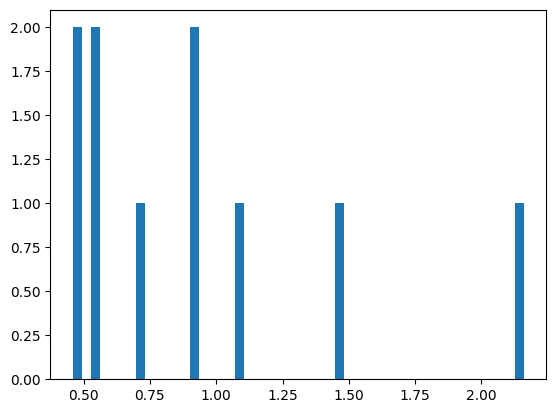

<Figure size 640x480 with 0 Axes>

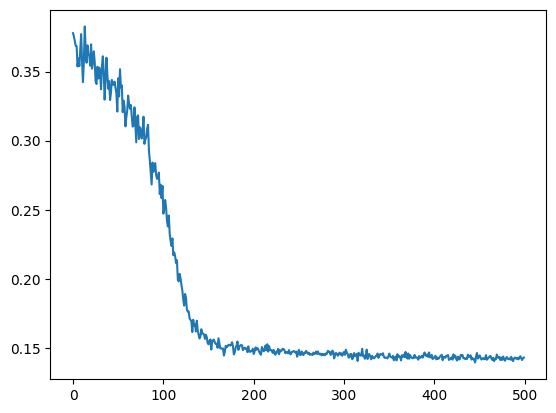

In [21]:
comparison_experiment.run_and_report(comparison_experiment.s4_experiment, epochs=epochs)

In [ ]:
comparison_experiment.run_and_report(comparison_experiment.dt_experiment, epochs=epochs)

In [ ]:
env_human = get_carnival_env(render_mode='human')

In [ ]:
# see and record
from algorithms.evaluate_policy import evaluate_policy

policy = comparison_experiment.make_dt_policy(rtg=1)
evaluate_policy(policy, env_human, num_eval_ep=1)

In [ ]:
# see and record
from algorithms.evaluate_policy import evaluate_policy

policy = comparison_experiment.make_s4_policy(rtg=1)
evaluate_policy(policy, env_human, num_eval_ep=1)